In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls -l '/content/drive/My Drive/MVTec_Vial_Project/'

total 8
drwx------ 2 root root 4096 May 12 19:08 'other files'
drwx------ 2 root root 4096 May 12 18:53  vial


In [3]:
!pip install -q opencv-python seaborn pandas # -q for quiet installation

# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2 #tf.keras.utils can also load images
import random
import shutil # For copying files

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


In [4]:
project_path = '/content/drive/My Drive/MVTec_Vial_Project/'

vial_data = os.path.join(project_path, 'vial')

# Check if the main vial directory exists
if not os.path.exists(vial_data):
    print(f"ERROR: Directory not found at {vial_data}")
    print("Please ensure you uploaded the 'vial' folder to the correct Google Drive path and adjusted GDRIVE_PROJECT_PATH.")
else:
    print(f"Base data path found: {vial_data}")

    # Define paths
    train_dir = os.path.join(vial_data, 'train')
    valid_dir = os.path.join(vial_data, 'validation')
    test_public_dir = os.path.join(vial_data, 'test_public')

    # Ensure paths are defined succesfully
    print("\nExpected subdirectories:")
    if os.path.exists(train_dir): print(f"- Found Train: {train_dir}")
    if os.path.exists(valid_dir): print(f"- Found Validation: {valid_dir}")
    if os.path.exists(test_public_dir): print(f"- Found Test Public: {test_public_dir}")

Base data path found: /content/drive/My Drive/MVTec_Vial_Project/vial

Expected subdirectories:
- Found Train: /content/drive/My Drive/MVTec_Vial_Project/vial/train
- Found Validation: /content/drive/My Drive/MVTec_Vial_Project/vial/validation
- Found Test Public: /content/drive/My Drive/MVTec_Vial_Project/vial/test_public


## Explore Data Structure

In [5]:
    #Training Data
    train_good_dir = os.path.join(train_dir, 'good') # Use train_dir defined previously
    if os.path.exists(train_good_dir):
        train_good_files = os.listdir(train_good_dir)
        print(f"Training 'good' images: {len(train_good_files)}")
    else:
        print(f"ERROR: Training 'good' directory not found at {train_good_dir}")

    #Validation Data
    validation_good_dir = os.path.join(valid_dir, 'good') # Use valid_dir defined previously
    if os.path.exists(validation_good_dir):
        validation_good_files = os.listdir(validation_good_dir)
        print(f"Validation 'good' images: {len(validation_good_files)}")
    else:
        # It's possible MVTec AD 2 validation doesn't have a 'good' subfolder, check base valid_dir
        validation_files = [f for f in os.listdir(valid_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))]
        if validation_files:
             print(f"Validation images (assuming all 'good'): {len(validation_files)}")
        else:
             print(f"WARNING: Validation directory structure might be different or empty: {valid_dir}")


    #Test Data
    if os.path.exists(test_public_dir): # Use test_public_dir defined previously
        print("\nTest Public Subfolders (Anomaly Types + 'good'):")
        test_subfolders = [f for f in os.listdir(test_public_dir) if os.path.isdir(os.path.join(test_public_dir, f))]
        print(test_subfolders)

        # Count images in each test subfolder
        test_counts = {}
        for folder in test_subfolders:
            folder_path = os.path.join(test_public_dir, folder)
            # Make sure to count only image files if other files exist
            img_files_in_folder = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))]
            test_counts[folder] = len(img_files_in_folder)


        print("\nTest Image Counts per Category:")
        # Use pandas Series for nice printing if available
        try:
            print(pd.Series(test_counts))
        except NameError: # If pandas wasn't imported or failed
             print(test_counts)

        anomaly_types = [f for f in test_subfolders if f != 'good']
        print(f"\nAnomaly Types Found: {anomaly_types}")

    else:
         print(f"ERROR: Test Public directory not found at {test_public_dir}")

Training 'good' images: 291
Validation 'good' images: 41

Test Public Subfolders (Anomaly Types + 'good'):
['ground_truth', 'good', 'bad']

Test Image Counts per Category:
ground_truth      0
good             35
bad             105
dtype: int64

Anomaly Types Found: ['ground_truth', 'bad']


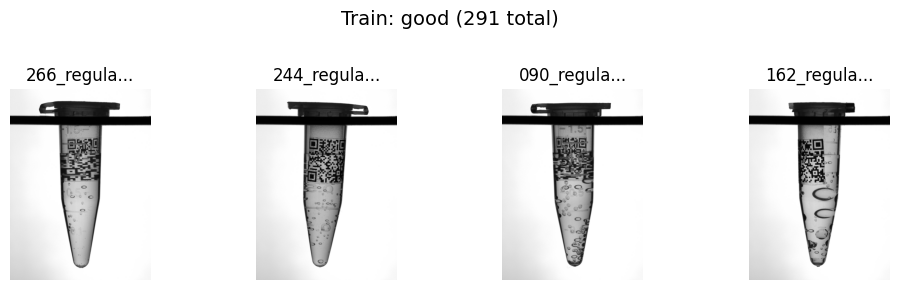

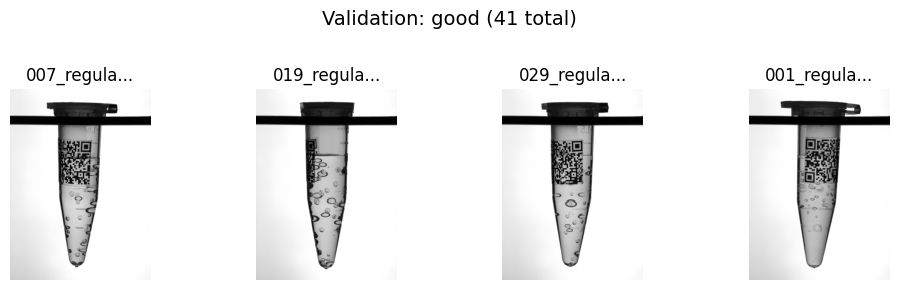

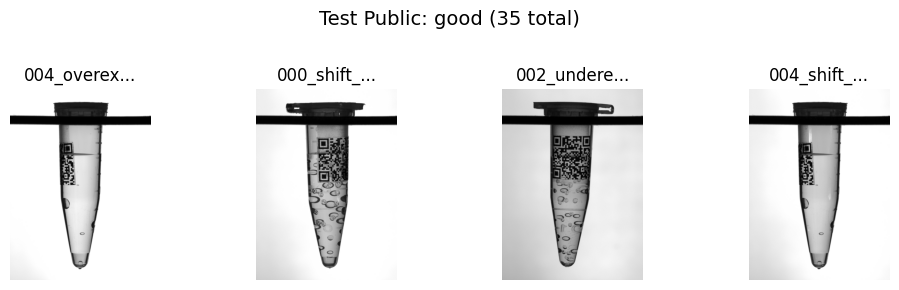

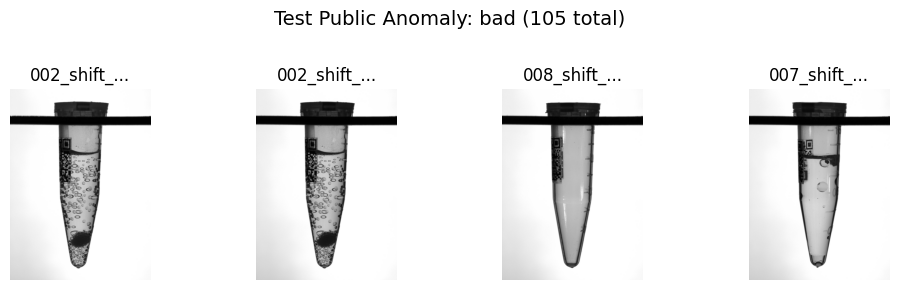

In [6]:
# Make sure necessary variables exist from the previous cell
if 'train_good_dir' not in locals(): train_good_dir = os.path.join(train_dir, 'good')
if 'validation_good_dir' not in locals(): validation_good_dir = os.path.join(valid_dir, 'good')
if 'anomaly_types' not in locals(): anomaly_types = [] # Initialize if not found previously


def plot_sample_images(base_dir, sub_dir, num_samples=4, title= "Sample Images"):
    "Plots a few random sample images from directory."
    img_folder = os.path.join(base_dir, sub_dir)
    if not os.path.exists(img_folder):
        # Handle cases where validation might not have 'good' subfolder
        if sub_dir == 'good' and base_dir == valid_dir:
             img_folder = base_dir # Try base validation directory
             if not os.path.exists(img_folder):
                  print(f"Directory not found: {img_folder}")
                  return
        else:
             print(f"Directory not found: {img_folder}")
             return

    img_files = [f for f in os.listdir(img_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))]
    if not img_files:
        print(f"No image files found in {img_folder}")
        return

    sample_files = random.sample(img_files, min(num_samples, len(img_files)))

    plt.figure(figsize=(10, 3 * ( (len(sample_files)-1)//4 + 1) ))
    plt.suptitle(f"{title}: {sub_dir} ({len(img_files)} total)", fontsize=14)

    for i, filename in enumerate(sample_files):
        img_path = os.path.join(img_folder, filename)
        try:
            img = mpimg.imread(img_path) # Use matplotlib first
        except Exception as e: # Fallback to OpenCV if mpimg fails
            print(f"mpimg failed on {filename}: {e}. Trying cv2.")
            try:
                img = cv2.imread(img_path)
                if img is None: raise ValueError("cv2 failed to load image")
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for matplotlib
            except Exception as cv_e:
                print(f"cv2 also failed on {filename}: {cv_e}. Skipping.")
                continue # Skip this image if loading fails

        plt.subplot((len(sample_files)-1)//4 + 1, 4, i + 1)
        plt.imshow(img, cmap='gray' if len(img.shape)==2 else None) # Show grayscale if needed
        plt.title(filename[:10] + "...") # Show partial filename
        plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

#Plotting
if os.path.exists(vial_data):
    # Plot Training 'good' samples
    plot_sample_images(train_dir, 'good', num_samples=4, title="Train")

    # Plot Validation 'good' samples
    plot_sample_images(valid_dir, 'good', num_samples=4, title="Validation")

    # Plot Test 'good' samples
    if os.path.exists(os.path.join(test_public_dir, 'good')):
      plot_sample_images(test_public_dir, 'good', num_samples=4, title="Test Public")

    #Plot Anomaly Samples
    # Get actual anomaly types
    actual_anomaly_folders = [atype for atype in anomaly_types if atype != 'ground_truth' and os.path.isdir(os.path.join(test_public_dir, atype))]

    # Plot first actual anomaly type samples (should be 'bad')
    if actual_anomaly_folders:
      first_anomaly_type = actual_anomaly_folders[0]
      plot_sample_images(test_public_dir, first_anomaly_type, num_samples=4, title="Test Public Anomaly")

    # Plot second actual anomaly type samples
    if len(actual_anomaly_folders) > 1:
      second_anomaly_type = actual_anomaly_folders[1]
      plot_sample_images(test_public_dir, second_anomaly_type, num_samples=4, title="Test Public Anomaly")

else:
    print("\nSkipping Visualization as base path ('vial (1)') was not found.")

## Model Development

In [7]:
# Define source and destination paths
# Source of bad images
source_bad_dir = os.path.join(test_public_dir, 'bad')

# Destination directories for copied bad images
train_bad_dir = os.path.join(train_dir, 'bad')
validation_bad_dir = os.path.join(valid_dir, 'bad')

#Create destination directories if they don't exist
os.makedirs(train_bad_dir, exist_ok=True)
os.makedirs(validation_bad_dir, exist_ok=True)

# Get list of bad images
if os.path.exists(source_bad_dir):
    bad_image_files = [f for f in os.listdir(source_bad_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))]
    print(f"Found {len(bad_image_files)} 'bad' images in the original test set.")

    # Shuffling the list first
    random.shuffle(bad_image_files)
    num_bad_total = len(bad_image_files)
    num_bad_train = int(num_bad_total * 0.8)
    num_bad_validation = num_bad_total - num_bad_train # The rest for validation

    bad_train_files = bad_image_files[:num_bad_train]
    bad_validation_files = bad_image_files[num_bad_train:]

    print(f"Copying {len(bad_train_files)} 'bad' images to {train_bad_dir}")
    print(f"Copying {len(bad_validation_files)} 'bad' images to {validation_bad_dir}")
    print(f"The original {test_public_dir} will still be used for final testing.")


    #Function to copy files
    def copy_files(file_list, source_dir, dest_dir):
        copied_count = 0
        for filename in file_list:
            src_path = os.path.join(source_dir, filename)
            dst_path = os.path.join(dest_dir, filename)
            try:
                shutil.copy2(src_path, dst_path) # copy2 preserves metadata
                copied_count += 1
            except Exception as e:
                print(f"Warning: Could not copy {filename}: {e}")
        return copied_count

    # --- Perform the copy ---
    copied_train = copy_files(bad_train_files, source_bad_dir, train_bad_dir)
    copied_val = copy_files(bad_validation_files, source_bad_dir, validation_bad_dir)

    print(f"\nSuccessfully copied {copied_train} 'bad' images to training.")
    print(f"Successfully copied {copied_val} 'bad' images to validation.")

    # Verify counts (optional)
    print(f"\nFiles in {train_bad_dir}: {len(os.listdir(train_bad_dir))}")
    print(f"Files in {validation_bad_dir}: {len(os.listdir(validation_bad_dir))}")

else:
    print(f"ERROR: Source directory for bad images not found: {source_bad_dir}")

Found 105 'bad' images in the original test set.
Copying 84 'bad' images to /content/drive/My Drive/MVTec_Vial_Project/vial/train/bad
Copying 21 'bad' images to /content/drive/My Drive/MVTec_Vial_Project/vial/validation/bad
The original /content/drive/My Drive/MVTec_Vial_Project/vial/test_public will still be used for final testing.

Successfully copied 84 'bad' images to training.
Successfully copied 21 'bad' images to validation.

Files in /content/drive/My Drive/MVTec_Vial_Project/vial/train/bad: 105
Files in /content/drive/My Drive/MVTec_Vial_Project/vial/validation/bad: 51


In [8]:
import tensorflow as tf

# --- Define constants ---
IMG_HEIGHT = 224
IMG_WIDTH = 224
# Consider reducing batch size if you hit RAM limits in Colab, but 32 is usually fine
BATCH_SIZE = 32
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
# Define class names explicitly to ensure 'good' is 0 and 'bad' is 1
CLASS_NAMES = ['good', 'bad']


# --- Create Training Dataset ---
# Uses the train_dir which now contains train/good and train/bad
print(f"\nCreating Training Dataset from: {train_dir}")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',        # Infers labels from directory structure
    label_mode='binary',      # For binary classification (0 or 1)
    class_names=CLASS_NAMES,  # Ensures 'good'=0, 'bad'=1
    image_size=IMG_SIZE,
    interpolation='nearest',  # Faster resizing, suitable for many tasks
    batch_size=BATCH_SIZE,
    shuffle=True,             # Shuffle training data
    seed=42                   # For reproducible shuffling
)

# --- Create Validation Dataset ---
# Uses the valid_dir which now contains validation/good and validation/bad
print(f"\nCreating Validation Dataset from: {valid_dir}")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels='inferred',
    label_mode='binary',
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False             # No need to shuffle validation data
    # No seed needed if shuffle=False
)

# --- Create Test Dataset ---
# Uses the original test_public_dir which contains test_public/good and test_public/bad
print(f"\nCreating Test Dataset from: {test_public_dir}")
# Important: Make sure test_public_dir has BOTH 'good' and 'bad' subfolders
# (Our file count earlier confirmed this: good=35, bad=105)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_public_dir,
    labels='inferred',
    label_mode='binary',
    class_names=CLASS_NAMES, # Crucial to map correctly
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False             # No need to shuffle test data
)

# --- Verify one batch from training dataset ---
print("\nVerifying one batch from training dataset:")
for images, labels in train_dataset.take(1):
    print("Images batch shape:", images.shape) # (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3)
    print("Labels batch shape:", labels.shape) # (BATCH_SIZE, 1) for binary
    print("Sample labels:", labels.numpy().flatten()[:5]) # Show first 5 labels in the batch

# --- Configure datasets for performance ---
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("\nTraining, Validation, and Test Datasets created and configured.")


Creating Training Dataset from: /content/drive/My Drive/MVTec_Vial_Project/vial/train
Found 396 files belonging to 2 classes.

Creating Validation Dataset from: /content/drive/My Drive/MVTec_Vial_Project/vial/validation
Found 92 files belonging to 2 classes.

Creating Test Dataset from: /content/drive/My Drive/MVTec_Vial_Project/vial/test_public
Found 140 files belonging to 2 classes.

Verifying one batch from training dataset:
Images batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 1)
Sample labels: [1. 0. 0. 0. 0.]

Training, Validation, and Test Datasets created and configured.


In [9]:
# Define Input Shape
IMG_SHAPE = IMG_SIZE + (3,) # IMG_SIZE was (224, 224), so IMG_SHAPE is (224, 224, 3)

# Load MobileNetV2 base model
# include_top=False removes the final classification layer
# weights='imagenet' loads weights pre-trained on ImageNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
# We don't want to train the pre-trained weights initially, only our new layers
base_model.trainable = False

# Let's look at the base model architecture
print("Base Model Summary (MobileNetV2):")
base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base Model Summary (MobileNetV2):


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Define a simple data augmentation layer (optional but recommended)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1), # Rotate by up to 10%
  # Add more if needed (e.g., RandomZoom, RandomContrast)
], name="data_augmentation")

# Define the function to preprocess inputs for MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Define the input layer
inputs = tf.keras.Input(shape=IMG_SHAPE, name="input_layer")

# Apply data augmentation (only active during training)
x = data_augmentation(inputs)

# Preprocess the input for the base model
x = preprocess_input(x)

# Pass input through the frozen base model
# training=False ensures BatchNormalization layers in MobileNetV2 run in inference mode
x = base_model(x, training=False)

# Add pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling")(x)

# Add dropout layer for regularization
x = tf.keras.layers.Dropout(0.2, name="dropout_layer")(x) # 20% dropout

# Add the final classification layer
# 1 unit (binary classification), sigmoid activation for probability (0 to 1)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name="output_layer")(x)

# Create the final model
model = tf.keras.Model(inputs, outputs)

# Print the full model summary
print("\nFull Model Summary:")
model.summary()


Full Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Define learning rate (can be tuned later)
base_learning_rate = 0.001

# Define metrics
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(), # Use BinaryCrossentropy for binary (0/1) output
              metrics=METRICS)

print("\nModel compiled successfully!")


Model compiled successfully!


In [17]:
# Train the Model

# Define number of epochs for this initial training run
initial_epochs = 11

print(f"Starting initial training for {initial_epochs} epochs...")

# Train the model
# We pass the training data, validation data, and number of epochs
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset) # Use the validation dataset created earlier

print(f"\nInitial training complete after {initial_epochs} epochs.")

# You can now analyze the 'history' object later to plot learning curves

Starting initial training for 11 epochs...
Epoch 1/11
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9139 - auc: 0.9523 - loss: 0.2745 - precision: 0.8736 - recall: 0.7553 - val_accuracy: 0.8478 - val_auc: 0.9660 - val_loss: 0.3726 - val_precision: 0.9302 - val_recall: 0.7843
Epoch 2/11
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8811 - auc: 0.9703 - loss: 0.2496 - precision: 0.8758 - recall: 0.6076 - val_accuracy: 0.8913 - val_auc: 0.9696 - val_loss: 0.3568 - val_precision: 0.9362 - val_recall: 0.8627
Epoch 3/11
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9092 - auc: 0.9588 - loss: 0.2623 - precision: 0.8608 - recall: 0.7380 - val_accuracy: 0.8261 - val_auc: 0.9713 - val_loss: 0.3690 - val_precision: 0.9268 - val_recall: 0.7451
Epoch 4/11
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8839 - auc: 0.9619 - loss: 0.2602 - precision: 0.8323 - recall: 0.6627 - val_accuracy: 0.8804 - val_auc: 0.9727 - val_loss: 0.3605 - val_precision: 0.9348 - val_recall: 

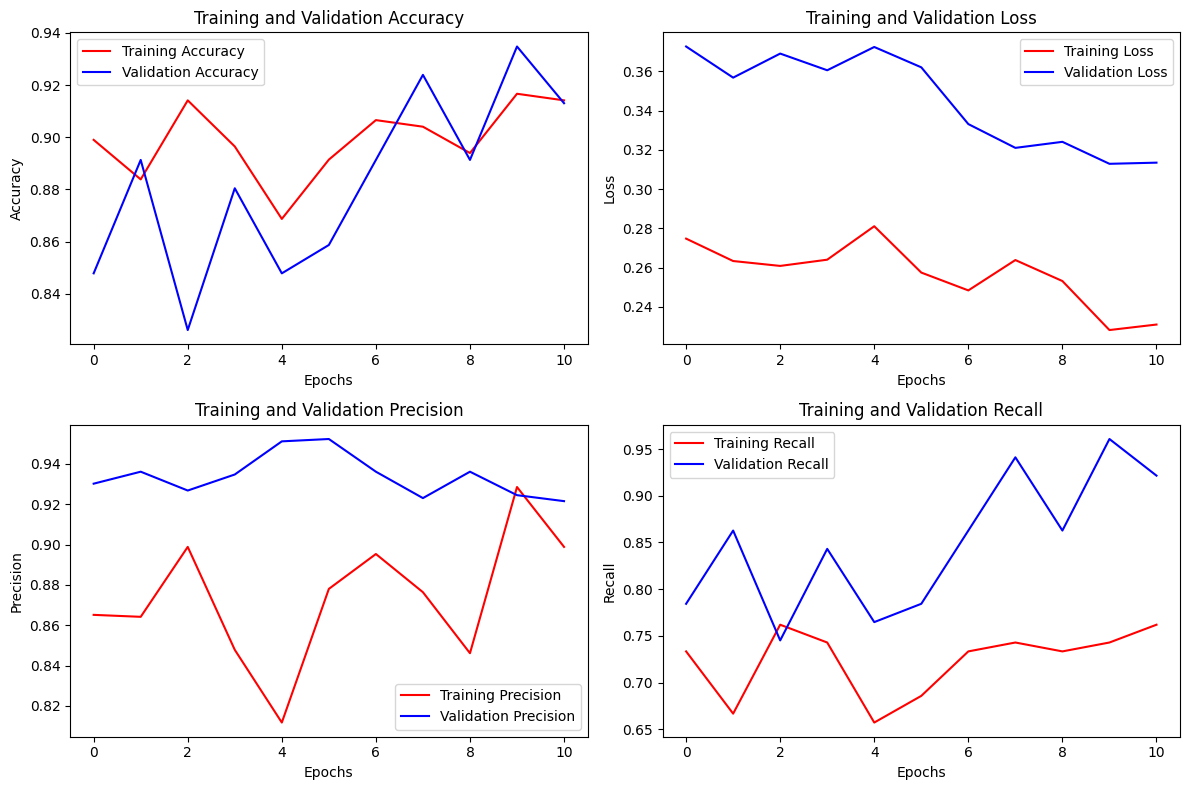

In [18]:
#Visualize Training History

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve results on training and validation datasets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
# Add other metrics if needed (e.g., precision, recall, auc)
precision = history.history.get('precision') # Use .get() in case metric wasn't recorded somehow
val_precision = history.history.get('val_precision')
recall = history.history.get('recall')
val_recall = history.history.get('val_recall')
auc = history.history.get('auc')
val_auc = history.history.get('val_auc')


epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1) # Adjusted subplot layout
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.subplot(2, 2, 2) # Adjusted subplot layout
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)

# --- Plot Precision and Recall (if available) ---
if precision and val_precision:
    plt.subplot(2, 2, 3) # Adjusted subplot layout
    plt.plot(epochs, precision, 'r', label='Training Precision')
    plt.plot(epochs, val_precision, 'b', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend(loc=0)

if recall and val_recall:
    plt.subplot(2, 2, 4) # Adjusted subplot layout
    plt.plot(epochs, recall, 'r', label='Training Recall')
    plt.plot(epochs, val_recall, 'b', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend(loc=0)


plt.tight_layout()
plt.show()

In [19]:
print("Evaluating model on the Test Set")

# Use the test_dataset we created earlier
results = model.evaluate(test_dataset)

# Assuming the standard order: Loss, Accuracy, Precision, Recall, AUC
print(f"Test Loss: {results[0]:.4f}")
if len(results) > 1: print(f"Test Accuracy: {results[1]:.4f}")
if len(results) > 2: print(f"Test Precision: {results[2]:.4f}")
if len(results) > 3: print(f"Test Recall: {results[3]:.4f}")
if len(results) > 4: print(f"Test AUC: {results[4]:.4f}")

# Store results in a dictionary for easier access if needed
test_results_dict = {}
metric_names_assumed = ['loss', 'accuracy', 'precision', 'recall', 'auc']
for i, name in enumerate(metric_names_assumed):
    if i < len(results):
        test_results_dict[name] = results[i]

print("\nTest results stored in test_results_dict:")
print(test_results_dict)


--- Evaluating model on the Test Set (Attempt 2) ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9573 - auc: 0.8333 - loss: 0.2504 - precision: 0.8333 - recall: 0.7720

--- Test Set Evaluation Results (Explicit Indices) ---
Test Loss: 0.2915
Test Accuracy: 0.9357
Test Precision: 1.0000
Test Recall: 0.9143
Test AUC: 1.0000

Test results stored in test_results_dict:
{'loss': 0.29146867990493774, 'accuracy': 0.9357143044471741, 'precision': 1.0, 'recall': 0.9142857193946838, 'auc': 1.0}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


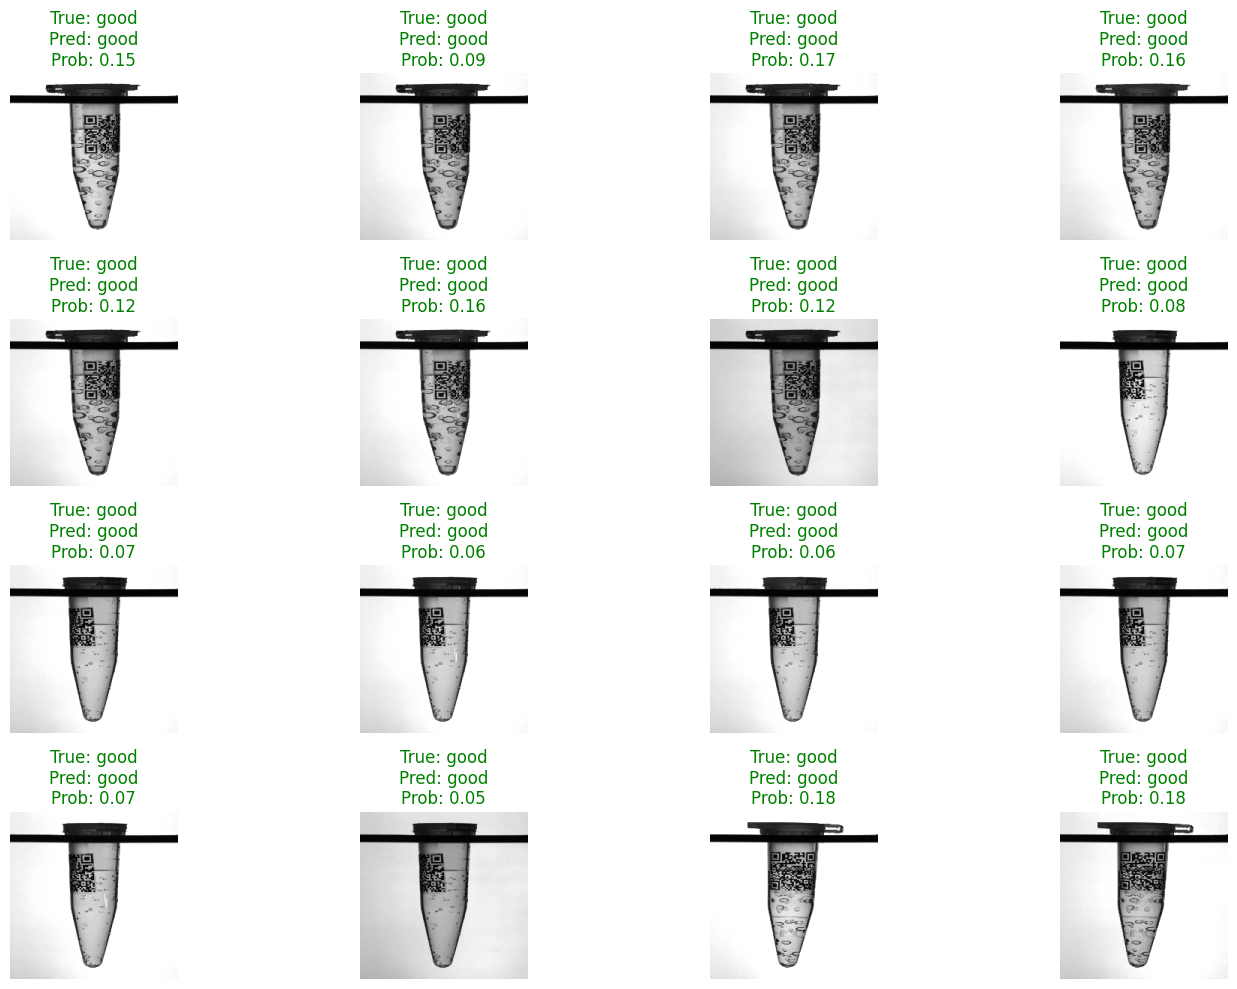


Prediction details for shown images:
Idx | True Label | Predicted Label | Probability (Bad) | Correct?
-----------------------------------------------------------------
0   | good       | good            | 0.1549            | Yes
1   | good       | good            | 0.0909            | Yes
2   | good       | good            | 0.1661            | Yes
3   | good       | good            | 0.1615            | Yes
4   | good       | good            | 0.1211            | Yes
5   | good       | good            | 0.1610            | Yes
6   | good       | good            | 0.1174            | Yes
7   | good       | good            | 0.0775            | Yes
8   | good       | good            | 0.0658            | Yes
9   | good       | good            | 0.0614            | Yes
10  | good       | good            | 0.0596            | Yes
11  | good       | good            | 0.0675            | Yes
12  | good       | good            | 0.0676            | Yes
13  | good       | good            | 

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- Make predictions on a batch from the test set ---
image_batch, label_batch = next(iter(test_dataset.take(1))) # Get one batch
predictions = model.predict(image_batch)

# The output 'predictions' are probabilities (due to sigmoid).
# Convert probabilities to class labels (0 or 1) using a 0.5 threshold.
predicted_labels = (predictions > 0.5).astype(int).flatten() # flatten for easier indexing

# Get the true labels for this batch
true_labels = label_batch.numpy().flatten().astype(int)

# --- Visualize the results ---
plt.figure(figsize=(15, 10)) # Adjust figure size if needed
num_images_to_show = min(BATCH_SIZE, 16) # Show up to 16 images from the batch

for i in range(num_images_to_show):
    ax = plt.subplot(4, 4, i + 1) # Arrange in a 4x4 grid
    plt.imshow(image_batch[i].numpy().astype("uint8")) # Display the image
    plt.axis("off")

    true_label_name = CLASS_NAMES[true_labels[i]]
    predicted_label_name = CLASS_NAMES[predicted_labels[i]]
    prediction_probability = predictions[i][0] # Get the raw probability

    # Set title color based on correctness
    title_color = 'green' if predicted_labels[i] == true_labels[i] else 'red'

    plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}\nProb: {prediction_probability:.2f}", color=title_color)

plt.tight_layout()
plt.show()

# --- Optional: Print comparison for the shown images ---
print("\nPrediction details for shown images:")
print("Idx | True Label | Predicted Label | Probability (Bad) | Correct?")
print("-----------------------------------------------------------------")
for i in range(num_images_to_show):
     is_correct = "Yes" if predicted_labels[i] == true_labels[i] else "NO!"
     print(f"{i: <3} | {CLASS_NAMES[true_labels[i]]: <10} | {CLASS_NAMES[predicted_labels[i]]: <15} | {predictions[i][0]:.4f}            | {is_correct}")

In [20]:
# Define a path to save the model in your Google Drive project folder
model_save_path = os.path.join(project_path, 'vial_classifier.keras') # Uses the path defined earlier

# Save the model
model.save(model_save_path)

print(f"Model saved successfully to: {model_save_path}")

Model saved successfully to: /content/drive/My Drive/MVTec_Vial_Project/vial_classifier.keras
